# PyTorch for Fast and Easy Machine Learning

**Matthew West**  
mwest@illinois.edu  
https://lagrange.mechse.illinois.edu/

_"Hands-On with CSE" tutorial series_

April 26, 2019

**Description:** PyTorch allows you to easily train and run machine learning models. It uses standard Python methods for writing code, so it's both simple and powerful. We will cover the core automatic differentiation capabilities of PyTorch, training deep neural networks, using GPUs and parallel computation, managing training and test data, saving and loading models, and visualizing training progress. We will assume a good knowledge of Python and NumPy, and basic knowledge of machine learning with neural nets.

# List of resources

- PyTorch tutorials: https://pytorch.org/tutorials/
- PyTorch manual: https://pytorch.org/docs/stable/index.html
- Calculus on computational graphs: http://colah.github.io/posts/2015-08-Backprop/
- Einstein summation in PyTorch: https://rockt.github.io/2018/04/30/einsum

# What is PyTorch?

- Like NumPy with automatic differentiation via dynamic computation graphs
- Transparent ability to compute on GPUs and in parallel
- Library of neural net functions and constructors
- Library of gradient-based optimizers
- Various other useful functions (e.g., data management)

# Installing PyTorch

- Use Anaconda
- https://pytorch.org/get-started/locally/
- At the moment we need Python 3.6 to support TensorBoard
```
conda create --name torch python=3.6
conda activate torch
conda install scipy matplotlib jupyter
conda install pytorch torchvision -c pytorch
pip install tensorflow # for TensorBoard
pip install tensorboardX # bridge from PyTorch
jupyter-notebook
```

# Let's get started!

In [143]:
import torch
import torch.utils.data
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch is similar to NumPy

PyTorch works in immediate mode, which is different to the default TensorFlow model.

PyTorch is very picky about datatypes, and defaults to single precision (NumPy defaults to double).

In [2]:
x = torch.tensor(3.0)

In [3]:
x

tensor(3.)

In [8]:
x.dtype

torch.float32

#### Set datatypes

use `dtype=torch.float64` and `.double()`

In [9]:
y = x.double()

In [10]:
y

tensor(3., dtype=torch.float64)

In [11]:
y.dtype

torch.float64

In [48]:
v = torch.tensor([1, 2, 3])

In [50]:
torch.log(v)

RuntimeError: "log" not implemented for 'torch.LongTensor'

In [51]:
v.dtype

torch.int64

In [52]:
v = torch.tensor([1, 2, 3], dtype=torch.float64)

In [53]:
torch.log(v)

tensor([0.0000, 0.6931, 1.0986], dtype=torch.float64)

#### Annoying differences from NumPy

`np.sum(x, axis=1)` versus `torch.sum(x, dim=1)`

`np.clip()` versus `torch.clamp()`

In [56]:
np.log([1, 2, 3]).clip(0, 1)

array([0.        , 0.69314718, 1.        ])

In [57]:
torch.log(v).clip(0, 1)

AttributeError: 'Tensor' object has no attribute 'clip'

In [58]:
torch.log(v).clamp(0, 1)

tensor([0.0000, 0.6931, 1.0000], dtype=torch.float64)

#### Convert to/from NumPy arrays

`.numpy()` and `torch.from_numpy()`

Memory is shared!

In [59]:
u = np.array([1, 2, 3])
v = torch.from_numpy(u)
v

tensor([1, 2, 3])

In [60]:
u[0] = 7
v

tensor([7, 2, 3])

# `torch.autograd`: Computing derivatives

PyTorch constructs the computation graph as you do operations (dynamic graphs) unlike TensorFlow (static graphs)

Using the computation graph, the chain rule (back propagation) can compute derivatives

In [118]:
x = torch.tensor(5.0)

In [119]:
y = torch.tensor(3.0, requires_grad=True)

In [120]:
z = x * y**2
z

tensor(45., grad_fn=<MulBackward0>)

In [121]:
z.backward()

In [122]:
print(f'x.grad = {x.grad}')

x.grad = None


In [123]:
y.grad

tensor(30.)

$z = x y^2$

$\frac{\partial z}{\partial y} = 2 x y$

In [124]:
2*x*y

tensor(30., grad_fn=<MulBackward0>)

#### Why are the derivatives in the leaves?

#### Control what we differentiate with respect to

`requires_grad=True`

`with no_grad():`

`.detach()`

In [129]:
x = torch.tensor(2.0, requires_grad=True)
y = x*x
print(f'y.requires_grad = {y.requires_grad}')
z = x*y
z.backward()
print(f'dz/dx = {x.grad}')

y.requires_grad = True
dz/dx = 12.0


In [130]:
x = torch.tensor(2.0, requires_grad=True)
y = x*x
y = y.detach() # can't say y.requires_grad = False
print(f'y.requires_grad = {y.requires_grad}')
z = x*y
z.backward()
print(f'dz/dx = {x.grad}')

y.requires_grad = False
dz/dx = 4.0


In [131]:
x = torch.tensor(2.0, requires_grad=True)
with torch.no_grad():
    y = x*x
print(f'y.requires_grad = {y.requires_grad}')
z = x*y
z.backward()
print(f'dz/dx = {x.grad}')

y.requires_grad = False
dz/dx = 4.0


#### Computation graphs are not trees

Re-using a parameter in multiple places makes the graph not be a tree

#### Computing second derivatives

Use `backward(create_graph=True)`

#### The computation graph is destroyed by `backward()`

To retain it for more differentiation, use `backward(retain_graph=True)`

A common use case is multiple outputs with a shared subgraph

Don't forget to free the graph on the last call to prevent memory leaks

In [95]:
x = torch.tensor(3.0, requires_grad=True)
y = x**2
z1 = 3*y
z2 = 4*y

In [96]:
z1.backward() # (retain_graph=True)
x.grad

tensor(18.)

In [97]:
z2.backward()
x.grad

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

#### Don't do in-place modifications to tensors

But it's fine to do `x = 4 * x`.

# Using a GPU

In [98]:
torch.cuda.is_available()

False

#### Create variables on the GPU

In [134]:
x = torch.ones(4, device="cuda")

AssertionError: Torch not compiled with CUDA enabled

#### Transfer variables to/from the GPU

In [135]:
x = torch.tensor([1, 2, 3])
y = torch.tensor([4, 5, 6])
x = x.to('cuda')
y = y.to('cuda')
z = x * y
z = z.to('cpu')
z

AssertionError: Torch not compiled with CUDA enabled

# `torch.optim`: All the common gradient-based optimizers

In [144]:
def f(x):
    return x**2

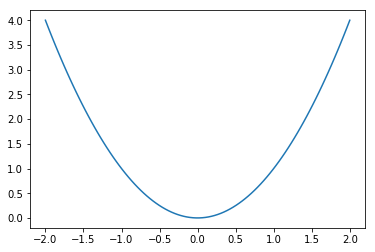

In [147]:
xvec = np.linspace(-2, 2, 100)
fvec = f(xvec)
plt.plot(xvec, fvec);

In [173]:
x = torch.tensor([2.0], requires_grad=True)

In [174]:
opt = torch.optim.SGD([x], lr=0.1)

In [175]:
x_history = [x.detach().numpy().copy()]
for i in range(10):
    print(f'##########')
    print(f'i = {i}')
    print(f'initial x = {x}')
    opt.zero_grad()
    z = f(x)
    print(f'z = {z}')
    z.backward()
    print(f'x.grad = {x.grad}')
    opt.step()
    print(f'updated x = {x}')
    x_history.append(x.detach().numpy().copy())

##########
i = 0
initial x = tensor([2.], requires_grad=True)
z = tensor([4.], grad_fn=<PowBackward0>)
x.grad = tensor([4.])
updated x = tensor([1.6000], requires_grad=True)
##########
i = 1
initial x = tensor([1.6000], requires_grad=True)
z = tensor([2.5600], grad_fn=<PowBackward0>)
x.grad = tensor([3.2000])
updated x = tensor([1.2800], requires_grad=True)
##########
i = 2
initial x = tensor([1.2800], requires_grad=True)
z = tensor([1.6384], grad_fn=<PowBackward0>)
x.grad = tensor([2.5600])
updated x = tensor([1.0240], requires_grad=True)
##########
i = 3
initial x = tensor([1.0240], requires_grad=True)
z = tensor([1.0486], grad_fn=<PowBackward0>)
x.grad = tensor([2.0480])
updated x = tensor([0.8192], requires_grad=True)
##########
i = 4
initial x = tensor([0.8192], requires_grad=True)
z = tensor([0.6711], grad_fn=<PowBackward0>)
x.grad = tensor([1.6384])
updated x = tensor([0.6554], requires_grad=True)
##########
i = 5
initial x = tensor([0.6554], requires_grad=True)
z = tensor([0.42

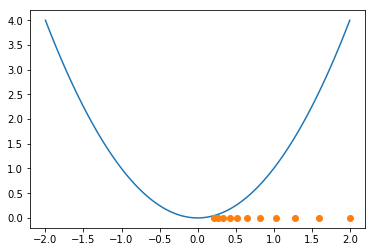

In [176]:
xvec = np.linspace(-2, 2, 100)
fvec = f(xvec)
plt.plot(xvec, fvec)
plt.plot(x_history, np.zeros(len(x_history)), 'o')

# `torch.nn`: Easy neural-network construction

Convention: the first index is the data-item index, so N images each of size 128x128 will be in a tensor like N x 128 x 128

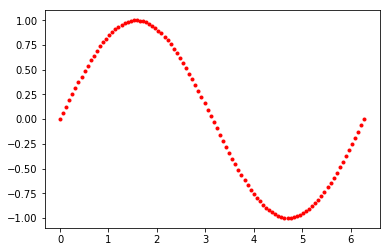

In [205]:
x = torch.linspace(0, 2*np.pi, 100)
y = torch.sin(x)
plt.plot(x.numpy(), y.numpy(), 'r.');

In [218]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = torch.nn.Linear(1, 8)
        self.fc2 = torch.nn.Linear(8, 8)
        self.fc3 = torch.nn.Linear(8, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [249]:
model = MyModel()

In [250]:
yp = model(x.reshape(100,1))

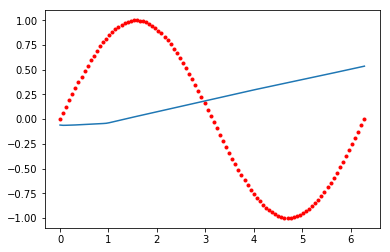

In [251]:
plt.plot(x.numpy(), y.numpy(), 'r.');
plt.plot(x.numpy(), yp.detach().numpy());

In [252]:
for p in model.parameters():
    print(p.shape)

torch.Size([8, 1])
torch.Size([8])
torch.Size([8, 8])
torch.Size([8])
torch.Size([1, 8])
torch.Size([1])


In [253]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_history = []

In [275]:
for i in range(10):
    opt.zero_grad()
    yp = model(x.reshape(100,1))
    loss = torch.nn.MSELoss()(yp, y.reshape(100,1))
    loss_history.append(loss.item())
    loss.backward()
    opt.step()

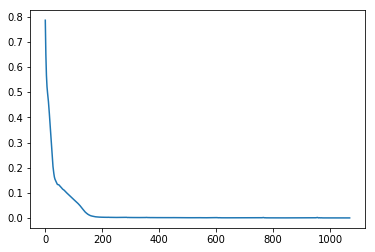

In [276]:
plt.plot(loss_history);

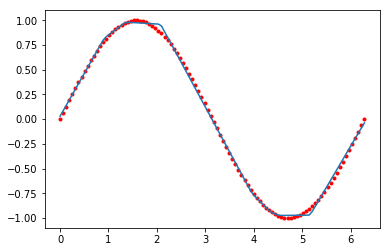

In [277]:
plt.plot(x.numpy(), y.numpy(), 'r.');
plt.plot(x.numpy(), yp.detach().numpy());

# Saving and restoring models

# Visualizing run-time output with TensorBoard

# `torch.utils.data`: Managing train/test data

In [148]:
x = torch.tensor([0,1,2,3,4,5,6,7,8,9])
y = torch.tensor([10,11,12,13,14,15,16,17,18,19])
d = torch.utils.data.TensorDataset(x, y)

In [216]:
d[0]

(tensor(0), tensor(10))

In [217]:
d[1]

(tensor(1), tensor(11))

In [223]:
(x_sample, y_sample) = d[random.sample(range(len(d)), 4)]
print(f'x_sample = {x_sample}')
print(f'y_sample = {y_sample}')

x_sample = tensor([2, 6, 7, 9])
y_sample = tensor([12, 16, 17, 19])
